In [1]:
using CSV
using DataFrames
using JSON
using ArchGDAL
using Proj
using Rasters
using Base.Threads
using JLD2
using Lux
using LuxCore
using EasyHybrid
using Optimisers
using Statistics
using Plots
using Distributed
include("helpers.jl")
using .Helpers
version = "v20251219"

"v20251219"

## Overlay

In [2]:
# load cov list
cov = JSON.parsefile("./cov_path_full.json");
pnames = collect(keys(cov))
paths = collect(values(cov))

res_m = 250 # meters
# load polygons
geom = ArchGDAL.read("nuts_de_2021.gpkg") do ds
    lyr = ArchGDAL.getlayer(ds, 0)
    ArchGDAL.getgeom(first(lyr))
end
env = ArchGDAL.envelope(geom)
bbox3035 = (env.MinX, env.MinY, env.MaxX, env.MaxY)
# bboxmine = (8.956051,51.815757,10.450192,53.154421) # examine area in northern DE, suggested by Bernhard
# bbox3035 = convert_bbox_wgs84_to_3035(bboxmine);
xs, ys = make_grid_3035(bbox3035, res_m);

# tf = Proj.Transformation("EPSG:3035", "EPSG:4326"); # because it's always 4326, so we do it in lazy way

In [3]:
tnames = pnames#[1:40]
tpaths = paths#[1:40]  
println("Julia threads: ", Threads.nthreads())
println("length: ", length(tpaths))

Julia threads: 96
length: 362


In [4]:
addprocs()

@everywhere begin
    using ArchGDAL
    using Proj
    include("helpers.jl")
    using .Helpers
end

out = pmap(i -> Helpers.sample_tiff_onto_grid(tpaths[i], xs, ys),
           eachindex(tpaths))

# chunk_size = 40
# out = Vector{Any}(undef, length(tpaths))
# m = Int[]
# lock_m = ReentrantLock()
# iii = 0
# for chunk in Iterators.partition(eachindex(tpaths), chunk_size)
#     println("chunk - $(iii)")

#     @time @threads for i in chunk
#         try
#             out[i] = sample_tiff_onto_grid(tpaths[i], xs, ys, tf)
#         catch
#             lock(lock_m) do
#                 push!(m, i)
#             end
#         end
#     end
    
#     iii = iii + 1
# end

362-element Vector{Vector{Float32}}:
 [32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  119.0, 107.0, 107.0, 214.0, 214.0, 236.0, 236.0, 221.0, 221.0, 220.0]
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  299.0, 291.0, 291.0, 291.0, 291.0, 291.0, 291.0, 291.0, 291.0, 256.0]
 [32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0  …  -393.0, -393.0, -393.0, -394.0, -394.0, -394.0, -289.0, -289.0, -289.0, -289.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [3455.0, 3455.0, 3455.0, 3455.0, 3455.0, 3455.0, 3455.0, 3455.0, 3455.0, 3455.0  …  2989.0, 2989.0, 2989.0, 3099.0, 3099.0, 3099.0, 3099.0, 3099.0, 3099.0, 3099.0]
 [32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0  …  0.0, 0.0, 0.0, 0.0

In [5]:
df = DataFrame()
nx = length(xs)
ny = length(ys)
df.x3035 = repeat(xs, inner=ny)
df.y3035 = repeat(ys, outer=nx)
for i in eachindex(tnames)
    df[!, Symbol(tnames[i])] = out[i]
end
println(size(df))

(8788409, 364)


In [6]:
using Parquet
write_parquet("overlaid_$(res_m)m_$(version).pq", df)

# CSV.write("overlaid_$(res_m)m_$(version).csv", df)

4

## prepare the data as how it's processed before training

In [7]:
# prepare data
# load in preprocessed data to get predictors
datafile = "/mnt/tupi/HybridModeling/EasyDensity.jl/data/lucas_preprocessed_v20251125.csv"
oridf = CSV.read(datafile, DataFrame; normalizenames=true)
predictors = Symbol.(names(oridf))[18:end-6]; # CHECK EVERY TIME 

In [8]:
using Statistics
# ? move the `csv` file into the `BulkDSOC/data` folder (create folder)
df_o = CSV.read("/mnt/tupi/HybridModeling/EasyDensity.jl/data/lucas_overlaid.csv", DataFrame, normalizenames=true);
println(size(df_o));

############################
###### clean targets #######
############################

# filter horizon depth = 10 cm
df_o = df_o[df_o.hzn_dep .== 10, :];
select!(df_o, Not(:hzn_dep));
println(size(df_o))

# identify noise time supervise
gdf = groupby(df_o, :id);
df_o.maxdiff = fill(0.0, nrow(df_o));  # initialize noise column
# compute max abs difference of SOCconc per id
for sub in groupby(df_o, :id)
    soc = sort(sub.soc)

    if length(soc) < 2
        maxdiff = -1
    else
        maxdiff = maximum(abs.(diff(soc)))
    end

    df_o[df_o.id .== sub.id[1], :maxdiff] .= maxdiff
    
end
println(size(df_o))
df_o = df_o[df_o.maxdiff .<= 50, :];
println(size(df_o))

# coords = collect(zip(df_o.lat, df_o.lon));

########################
###### clean cov #######
########################
# t clean covariates
names_cov = Symbol.(names(df_o))[18:end-1];

# Fix soilsuite and cropland extent columns
for col in names_cov
    if occursin("_soilsuite_", String(col))
        df_o[!, col] = replace(df_o[!, col], missing => 0)
    elseif occursin("cropland_extent_", String(col))
        df_o[!, col] = replace(df_o[!, col], missing => 0)
        df_o[!, col] .= ifelse.(df_o[!, col] .> 0, 1, 0)
    end
end

# rm missing values: 1. >5%, drop col; 2. <=5%, drop row
cols_to_drop_row = Symbol[];
cols_to_drop_col = Symbol[];
for col in names_cov
    n_missing = count(ismissing, df_o[!, col])
    frac_missing = n_missing / nrow(df_o)
    if frac_missing > 0.05
        println(n_missing, " ", col)
        select!(df_o, Not(col))  # drop the column
        push!(cols_to_drop_col, col)  
    elseif n_missing > 0
        # println(n_missing, " ", col)
        push!(cols_to_drop_row, col)  # collect column name
    end

    if occursin("CHELSA_kg", String(col)) 
        push!(cols_to_drop_col, col) 
        select!(df_o, Not(col))  # rm kg catagorical col
    end 
end

names_cov = filter(x -> !(x in cols_to_drop_col), names_cov) # remove cols-to-drop from names_cov
if !isempty(cols_to_drop_row) 
    df_o = subset(df_o, cols_to_drop_row .=> ByRow(!ismissing)) # drop rows with missing values in cols_to_drop_row
end
println(size(df_o))

cols_to_drop_col = Symbol[] 
for col in names_cov
    if std(df_o[:,col])==0
        push!(cols_to_drop_col, col)  # rm constant col (std==0)
        select!(df_o, Not(col))
    end
end
names_cov = filter(x -> !(x in cols_to_drop_col), names_cov) # remove cols-to-drop from names_cov
println(size(df_o))

# for col in names_cov # to check covairate distribution
#     println(string(col)[1:10], ' ', round(std(df[:, col]); digits=2), ' ', round(mean(df[:, col]); digits=2))
# end

# # Normalize covariates by (x-mean) / std
means = map(c -> mean(skipmissing(df_o[!, c])), predictors);
stds  = map(c -> std(skipmissing(df_o[!, c])), predictors);


(62577, 422)
(62199, 421)
(62199, 422)
(57343, 422)
33487 CHELSA_swe_1981_2010_V_2_1
(56117, 415)
(56117, 380)


362-element Vector{Float64}:
    0.4957194992987643
   20.889662172398452
   16.176804972325215
   32.70255955009699
   20.72422091115271
    6.962051706055117
  303.292063090729
   20.090713703342438
   16.826666552938825
  175.60961067645266
    4.38550494686176
   16.61863526446851
  243.25463545594974
    ⋮
   16.384190289457294
  317.24370807573996
    9.122982738527044
    2.702028128432284
  949.339911321499
 2776.1597732031746
    0.8442501834141488
 1174.1247065586917
  723.6275157944917
   36.54252785078271
   21.96077313715635
   74.81349636789484

In [9]:
## apply the normalizations to new training data
# get the overlaid data
version = "v20251219"
df = read_parquet("overlaid_$(res_m)m_$(version).pq")
# df = CSV.read("overlaid_$(version).csv", DataFrame)

# mend crop and soil suite layers
for col in predictors
    if occursin("_soilsuite_", String(col))
        df[!, col] = replace(df[!, col], missing => 0)
    elseif occursin("cropland_extent_", String(col))
        df[!, col] = replace(df[!, col], missing => 0)
        df[!, col] .= ifelse.(df[!, col] .> 0, 1, 0)
    end
end

for (i, col) in enumerate(predictors)
    df[!, col] = (Float64.(df[!, col]) .- means[i]) ./ stds[i]
end


In [10]:
clean(x) = filter(!isnan, skipmissing(x))

rows = Vector{NamedTuple}()

for col in predictors
    v_o = clean(oridf[!, col])
    v_d = clean(df[!, col])

    push!(rows, (
        variable   = String(col),
        q05_oridf  = quantile(v_o, 0.05),
        q05_df     = quantile(v_d, 0.05),
        q50_oridf  = quantile(v_o, 0.50),
        q50_df     = quantile(v_d, 0.50),
        q95_oridf  = quantile(v_o, 0.95),
        q95_df     = quantile(v_d, 0.95)
    ))
end

qt = DataFrame(rows)
CSV.write("predictor_quantiles_check.csv", qt)


"predictor_quantiles_check.csv"

In [11]:
write_parquet("production_preprocessed_$(res_m)m_$(version).pq", df)
# CSV.write("production_preprocessed_$(res_m)m_$(version).csv", df)

4

## load model, retrain on all data and predict

In [14]:
# jldfile = "/mnt/tupi/HybridModeling/EasyDensity.jl/model/best_model_03_hybridNN_config105_fold4.jld2"
# hm = load_last_epoch(jldfile);
# ps = hm[1]
# st = hm[2]

# parameters
scalers = Dict(
    :SOCconc   => 0.151, # g/kg, log(x+1)*0.151
    :CF        => 0.263, # percent, log(x+1)*0.263
    :BD        => 0.529, # g/cm3, x*0.529
    :SOCdensity => 0.167, # kg/m3, log(x)*0.167
);
function SOCD_model(; SOCconc, CF, oBD, mBD)
    ϵ = 1e-7

    # invert transforms
    soct = (exp.(SOCconc ./ scalers[:SOCconc]) .- 1) ./ 1000
    soct = clamp.(soct, ϵ, Inf)
    
    cft = (exp.(CF ./ scalers[:CF]) .- 1) ./ 100
    cft = clamp.(cft, 0, 0.99)

    # compute BD safely
    som = 1.724f0 .* soct
    som = clamp.(som, 0, 1) # test!!!!!!!!
    
    denom = som .* mBD .+ (1f0 .- som) .* oBD
    # denom = clamp.(denom, ϵ, Inf)

    BD = (oBD .* mBD) ./ denom
    BD = clamp.(BD, ϵ, Inf)

    # SOCdensity
    SOCdensity = soct .* 1000 .* BD .* (1 .- cft)
    SOCdensity = clamp.(SOCdensity, 1, Inf)

    # scale
    SOCdensity = log.(SOCdensity) .* scalers[:SOCdensity]
    BD = BD .* scalers[:BD]

    return (; BD, SOCconc, CF, SOCdensity, oBD, mBD)
end
parameters = (
    SOCconc = (0.01f0, 0.0f0, 1.0f0),   # fraction
    CF      = (0.15f0, 0.0f0, 1.0f0),   # fraction,
    oBD     = (0.20f0, 0.05f0, 0.40f0),  # also NN learnt, g/cm3
    mBD     = (1.20f0, 0.75f0, 2.0f0),  # NN leanrt
)
neural_param_names = [:SOCconc, :CF, :mBD, :oBD]
forcing = Symbol[]
targets = [:BD, :SOCconc, :SOCdensity, :CF]   

hmb = constructHybridModel(
    predictors,
    forcing,
    targets,
    SOCD_model,
    parameters,
    neural_param_names,
    [];
    hidden_layers = [256, 128, 64, 32],
    activation = gelu,
    scale_nn_outputs = true,
    input_batchnorm = false,
    start_from_default = true
);

rlt = train(
    hmb, oridf, ();
    nepochs = 200,
    batchsize = 512,
    opt = AdamW(0.0005),
    training_loss = :mse,
    loss_types = [:mse, :r2],
    shuffleobs = true,
    file_name = "prod_SiNN.jld2",
    random_seed = 42,
    patience = 15,
    yscale = identity,
    monitor_names = [:oBD, :mBD],
    agg = mean,
    return_model = :best,
    show_progress = false,
    plotting = false,
    hybrid_name = "prod_SiNN" 
)


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/PjjBT/src/train.jl:156
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl-main/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014769173349902721
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/PjjBT/src/train.jl:319
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014769173349902721


  train_history: (20, 2)
    mse  (BD, SOCconc, SOCdensity, CF, mean)
    r2   (BD, SOCconc, SOCdensity, CF, mean)
  val_history: (20, 2)
    mse  (BD, SOCconc, SOCdensity, CF, mean)
    r2   (BD, SOCconc, SOCdensity, CF, mean)
  ps_history: (20, 2)
    ϕ        ()
    monitor  (train, val)
  train_obs_pred: 44894×9 DataFrame
    BD, SOCconc, SOCdensity, CF, index, BD_pred, SOCconc_pred, SOCdensity_pred, CF_pred
  val_obs_pred: 11223×9 DataFrame
    BD, SOCconc, SOCdensity, CF, index, BD_pred, SOCconc_pred, SOCdensity_pred, CF_pred
  train_diffs: 
    oBD         (44894,)
    mBD         (44894,)
    parameters  (SOCconc, CF, mBD, oBD)
  val_diffs: 
    oBD         (11223,)
    mBD         (11223,)
    parameters  (SOCconc, CF, mBD, oBD)
  ps: 
    ps  (layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)
  st: 
    st     (layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)
    fixed  ()
  best_epoch: 
  best_loss: 


In [16]:
# get the preprocessed overlaid data
# df = read_parquet("production_preprocessed_$(res_m)m_$(version).pq")
# df = CSV.read("production_preprocessed_$(res_m)m_$(version).csv", DataFrame)
x_test = to_keyedArray(Float32.(df[!, predictors]));

ps, st = rlt.ps, rlt.st
ŷ_test, st_test = hmb(x_test, ps, LuxCore.testmode(st))

# prediction
for var in [:BD, :SOCconc, :CF, :SOCdensity, :oBD, :mBD]
    if hasproperty(ŷ_test, var)
        val = getproperty(ŷ_test, var)

        if val isa AbstractVector && length(val) == nrow(df)
            df[!, Symbol("pred_", var)] = val # per row

        elseif (val isa Number) || (val isa AbstractVector && length(val) == 1)
            df[!, Symbol("pred_", var)] = fill(Float32(val isa AbstractVector ? first(val) : val), nrow(df))
        end
    end
end

# inverse SOC concentration (g/kg)
df[!, :soc] = exp.(df[!, :pred_SOCconc] ./ scalers[:SOCconc]) .- 1;
# inverse CF (fraction, NOT percent)
df[!, :cf] = (exp.(df[!, :pred_CF] ./ scalers[:CF]) .- 1) ./ 100;
# inverse bulk density (g/cm3)
df[!, :bd] = df[!, :pred_BD] ./ scalers[:BD];
# inverse SOC density (kg/m3)
df[!, :ocd] = exp.(df[!, :pred_SOCdensity] ./ scalers[:SOCdensity]);

println(size(df))
save_col = [
    :x3035, :y3035,
    :pred_SOCconc, :pred_CF, :pred_BD,
    :pred_SOCdensity,
    :soc, :ocd, :bd, :cf
]
write_parquet("out_$(res_m)m_$(version).pq", df[:, save_col])

# CSV.write("out_$(res_m)m_$(version).csv", df[:, save_col])


(8788409, 374)


4

## check predictions

Variable: pred_BD
  Valid count = 8788409
  Min = 0.02644999941094641
  Max = 1.0579928864792316



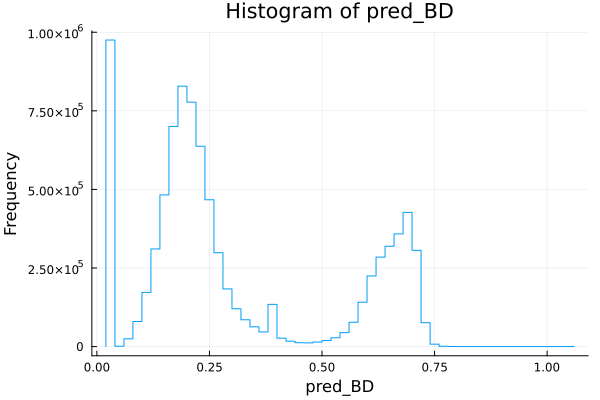

Variable: pred_SOCconc
  Valid count = 8788409
  Min = 0.0
  Max = 1.0



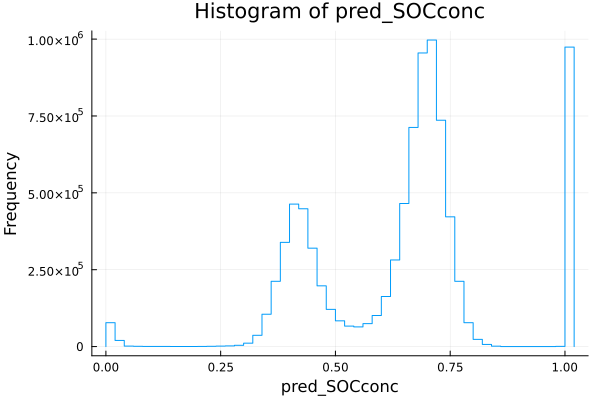

Variable: pred_CF
  Valid count = 8788409
  Min = 0.0
  Max = 1.0



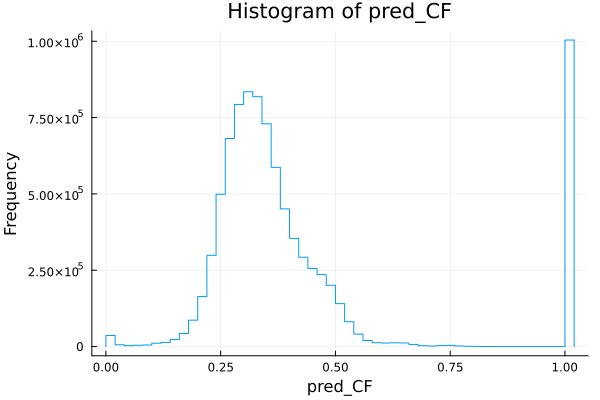

Variable: pred_SOCdensity
  Valid count = 8788409
  Min = 0.0
  Max = 0.7011775819690915



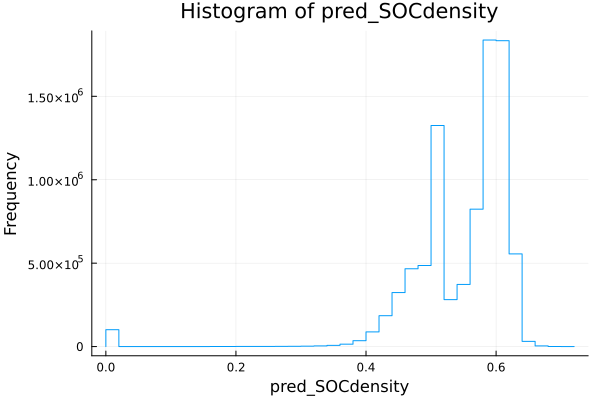

In [17]:
using Statistics
using Plots
for col in ["pred_BD", "pred_SOCconc", "pred_CF", "pred_SOCdensity"]

    vals = df[:, col]

    # 有效值（非 missing 且非 NaN）
    valid_vals = filter(x -> !ismissing(x) && !isnan(x), vals)

    n_valid = length(valid_vals)
    vmin = minimum(valid_vals)
    vmax = maximum(valid_vals)

    println("Variable: $col")
    println("  Valid count = $n_valid")
    println("  Min = $vmin")
    println("  Max = $vmax\n")

    histogram(
        vals;
        bins = 50,
        xlabel = col,
        ylabel = "Frequency",
        title = "Histogram of $col",
        lw = 1,
        legend = false
    )
    display(current())
end

## save as tiff

In [45]:
const AG = ArchGDAL

function write_geotiff_from_grid(df::DataFrame, value_col::Symbol, filename::String)
    xs = sort(unique(df.x3035))
    ys = sort(unique(df.y3035), rev=true)

    nx, ny = length(xs), length(ys)
    grid = fill(NaN, ny, nx)

    x_index = Dict(x => i for (i, x) in enumerate(xs))
    y_index = Dict(y => i for (i, y) in enumerate(ys))

    for r in eachrow(df)
        grid[y_index[r.y3035], x_index[r.x3035]] = r[value_col]
    end

    dx = xs[2] - xs[1]
    dy = ys[1] - ys[2]

    drv = ArchGDAL.getdriver("GTiff")

    ArchGDAL.create(
        drv;
        filename = filename,
        width = nx,
        height = ny,
        nbands = 1,
        dtype = Float64
    ) do ds
        ArchGDAL.setproj!(ds, "EPSG:3035")
        ArchGDAL.setgeotransform!(
            ds,
            [xs[1] - dx/2, dx, 0.0, ys[1] + dy/2, 0.0, -dy]
        )
        ArchGDAL.write!(ds, permutedims(grid, (2,1)), 1)
        # ArchGDAL.write!(ds, grid, 1)
    end
end



write_geotiff_from_grid (generic function with 2 methods)

In [46]:
for var in [:bd, :soc, :cf, :ocd, :pred_oBD, :pred_mBD]
    write_geotiff_from_grid(
        df,
        var,
        "pred_$(var).tif"
    )
end

In [30]:
for var in [:bd, :soc, :cf, :ocd, :pred_oBD, :pred_mBD]
    write_geotiff_from_grid(
        df,
        xs,
        ys,
        var,
        "pred_$(var).tif"
    )
end